# Covariance for a toy model with modulation

In [1]:
import sys
import os
import scipy
# from scipy.signal import tukey
from scipy.signal.windows import tukey
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve

from tqdm import tqdm as tqdm

import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

# Modulation definitions

In [2]:
def h(a, f0, fdot0, t, w_t = 1.0):
    """
    Inputs: Amplitude a (scalar)
            Initial frequency (scalar)
            Chirp dotf0 (scalar)
            Time (ndarray) t
            w_t window function (optional)
            
    Outputs:
            Waveform time series
    """
    
    return w_t * 3e-22*(a * np.sin((2*np.pi)*t*(f0 + fdot0 * t)))

def modulation(A,B, t, T_obs):

    w_t = A + B*np.cos(2*np.pi * t / (T_obs))
    return w_t

def Sn(f):
    """
    PSD obtained from: https://arxiv.org/pdf/1803.01944.pdf
    Removed galactic confusion noise.
    """        
    
    sky_averaging_constant = (20/3) # Sky Averaged 
    L = 2.5*10**9   # Length of LISA arm
    f0 = 19.09*10**-3    

    Poms = ((15e-12)**2)*(1 + ((2*1e-3)/f)**4)  # Optical Metrology Sensor
    Pacc = (3*1e-15)**2*(1 + (4*1e-4/(f))**2)*(1 + (f/(8e-3))**4)  # Acceleration Noise  

    PSD = ((10/(3*L**2))*(Poms + (4*Pacc)/((2*np.pi*f))**4)*(1 + 0.6*(f/f0)**2))

    return PSD

def Sc(f):
    """
    Inputs: Frequency (ndarray)
    Outputs: Confusion background
    """
    return (9*10**(-45)*f**(-7/3)*np.exp(-f**0.171 + 292*f*np.sin(1020*f)) * (1 \
                                            + np.tanh(1680*(0.00215 - f))) )

def Full_PSD(f):
    return Sn(f) + Sc(f)

# Generate PSD and modulation

In [3]:
tmax = 30*60*60    # Final time
fmax = 1e-7 * 1 * tmax   # maximum frequency
fs = 2*fmax                    # Sampling rate
delta_t = np.floor(0.7/fs)        # Sampling interval

t = np.arange(0,tmax,delta_t)   # Form time vector from t0 = 0 to tn = tmax
N = int(2 ** (np.ceil(np.log2(len(t)))))  # Round length of time series to a power of two.

t_pad = np.arange(0, N * delta_t, delta_t)
T_obs = N*delta_t

# Set up modulation parameters
A = 1
B = 0.5

# Compute modulation function, time domain
w_t = modulation(A,B,t_pad, T_obs)

freq_bin = np.fft.fftshift(np.fft.fftfreq(N,delta_t))   # Generate sampling frequencies. Two sided.        
Delta_f = freq_bin[N//2 + 1]
PSD_conf = Sc(freq_bin)

delta_f = freq_bin[1] - freq_bin[0]

In [4]:
N, t_pad.shape, freq_bin.shape, PSD_conf.shape

(4096, (4096,), (4096,), (4096,))

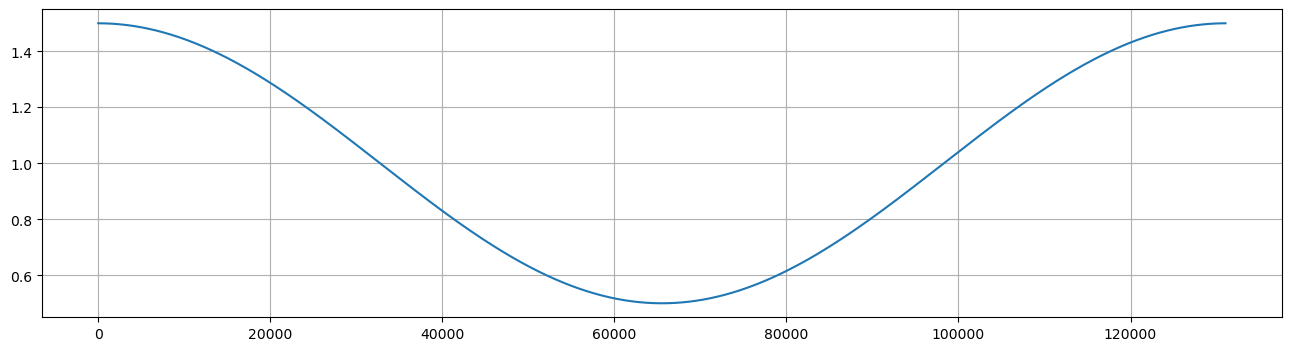

In [6]:
fig, ax = plt.subplots(1,1, figsize=[16,4])
ax.plot(t_pad,w_t)
ax.grid()
# plotutils.lplot(ax, [t_pad, w_t], rangey=[0,2])

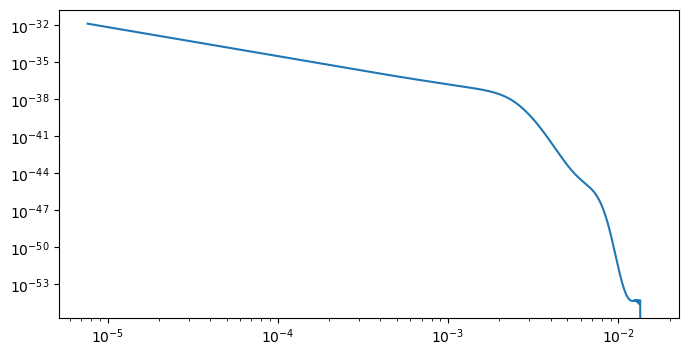

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.loglog(freq_bin[N//2+1:], PSD_conf[N//2+1:])

In [8]:
# Generate positive frequencies
freq_pos = freq_bin[N//2:]

Sn_pos = np.zeros(N//2, dtype=float)
Sn_pos[1:] = Sc(freq_pos[1:])
Sn_pos[0] = Sn_pos[1]

Sn = np.zeros(N, dtype=float)
Sn[:N//2] = Sn_pos
Sn[N//2+1:] = Sn_pos[1:][::-1]
Sn[N//2] = Sc(N//2 * delta_f)

Sigma_tilde_diag = Sn / (2*delta_f)

# Generate noise covariance matrix in frequency domain
Sigma_tilde = np.diag(Sigma_tilde_diag)

# FFT via linear algebra

In [9]:
omega = np.exp(2*1j*np.pi/N)

P = np.zeros((N,N), dtype=complex)
Pinv = np.zeros((N,N), dtype=complex)
# Very slow, very dumb
for i in tqdm(range(N)):
    for j in range(N):
        P[i,j] = 1./np.sqrt(N) * omega**(i*j)
        Pinv[i,j] = 1./N * 1./P[i,j]

100%|██████████| 4096/4096 [00:17<00:00, 233.98it/s]


In [10]:
P_test = 1./np.sqrt(N) * np.conj(scipy.linalg.dft(N))

In [13]:
# Check, build DFT matrix
print("Check:",np.allclose(P, P_test))
print("Check:",np.allclose(P@Pinv, np.diag(np.ones(N))))

Check: True
Check: True


In [14]:
W = np.diag(w_t)

W_tilde = P @ W @ Pinv

Sigma_tilde_w = W_tilde @ Sigma_tilde @ W_tilde

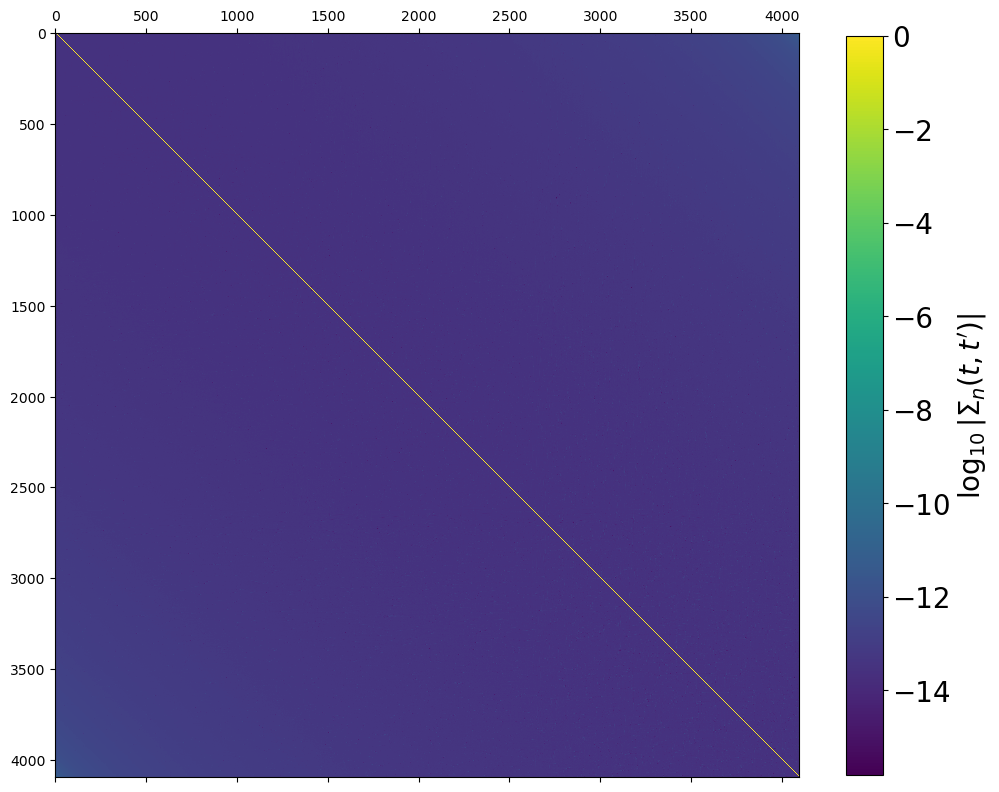

In [17]:
# NOTE: we do not see off-diagonal terms on this scale

fig, ax = plt.subplots(1,1, figsize=[12,12])
mat = ax.matshow(np.log10(np.abs(W_tilde)), vmin = np.min(np.log10(np.abs(W_tilde))), vmax = np.max(np.log10(np.abs(W_tilde))))
cbar = fig.colorbar(mat, location='right', shrink=0.8)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = r'$\log_{10}|\Sigma_{n}(t,t^{\prime})|$', fontsize = 20)

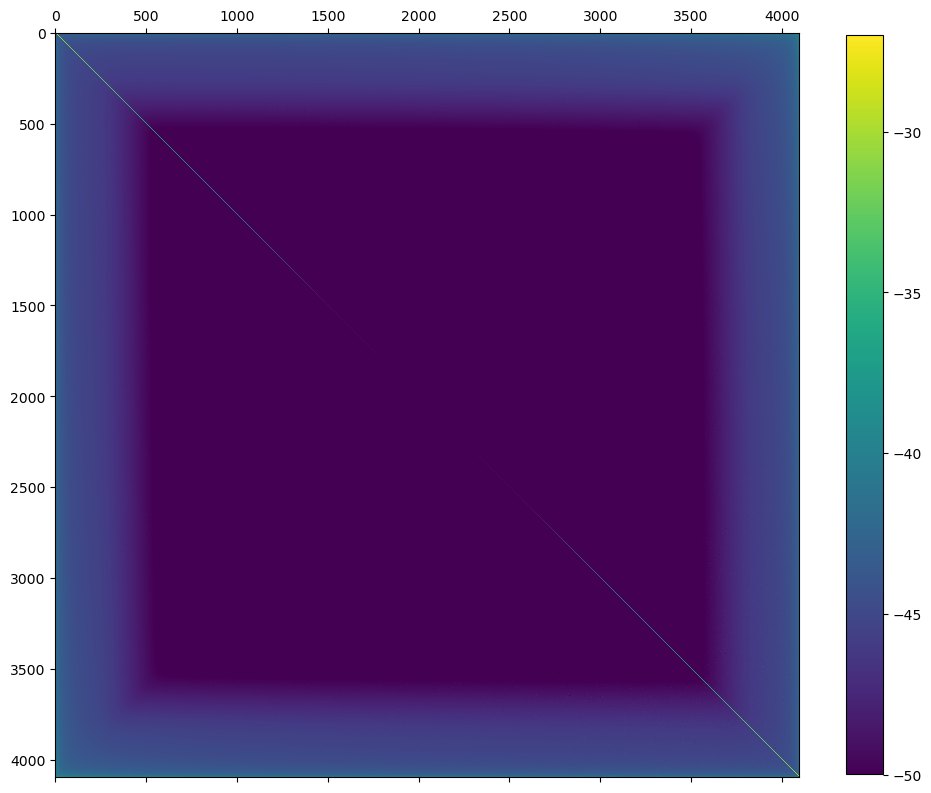

In [19]:
# NOTE: we do not see off-diagonal terms on this scale - square edges are due to numerical noise

fig, ax = plt.subplots(1,1, figsize=[12,12])
mat = ax.matshow(np.log10(np.abs(Sigma_tilde_w)), vmin=-50, vmax=-27)
cbar = fig.colorbar(mat, location='right', shrink=0.8)
# cbar.set_xticks(fontsize = 20)
# cbar.set_label(label = r'$\log_{10}|\Sigma_{n}(t,t^{\prime})|$', fontsize = 20)

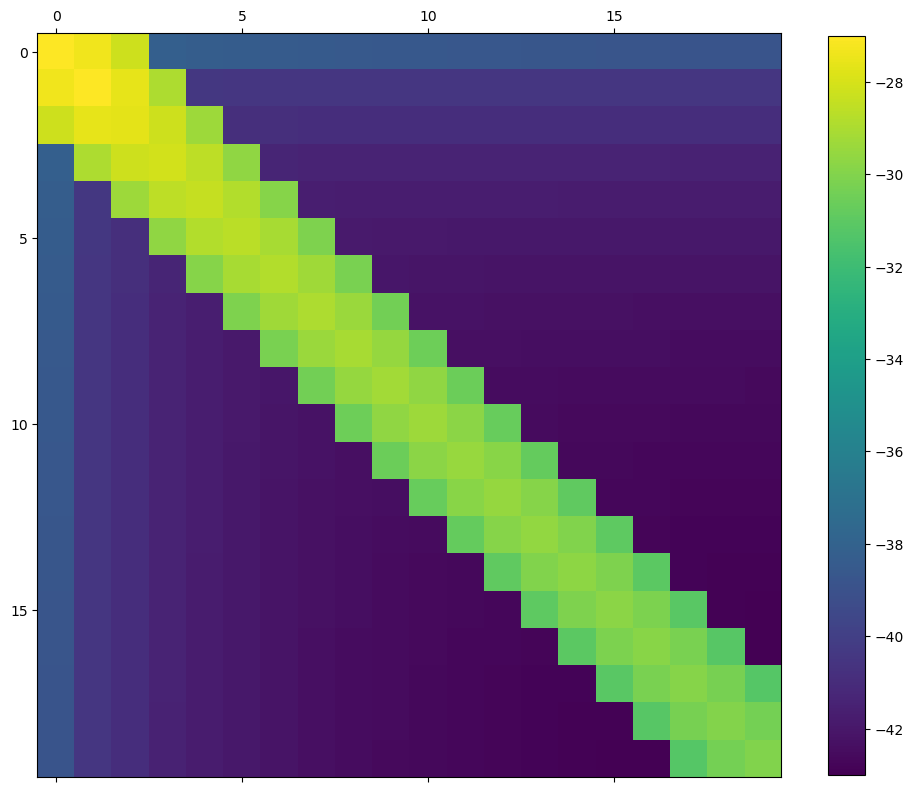

In [20]:
N_plot = 20

fig, ax = plt.subplots(1,1, figsize=[12,12])
mat = ax.matshow(np.log10(np.abs(Sigma_tilde_w[:N_plot,:N_plot])), vmin=-43, vmax=-27)
cbar = fig.colorbar(mat, location='right', shrink=0.8)
# cbar.set_xticks(fontsize = 20)
# cbar.set_label(label = r'$\log_{10}|\Sigma_{n}(t,t^{\prime})|$', fontsize = 20)

In [21]:
# Cleaning first off-2-diagonal terms in Wtilde

W_tilde_clean = np.copy(W_tilde)
W_tilde_clean[np.abs(W_tilde) < 1e-8] = 0.

Sigma_tilde_w_clean = W_tilde_clean @ Sigma_tilde @ W_tilde_clean

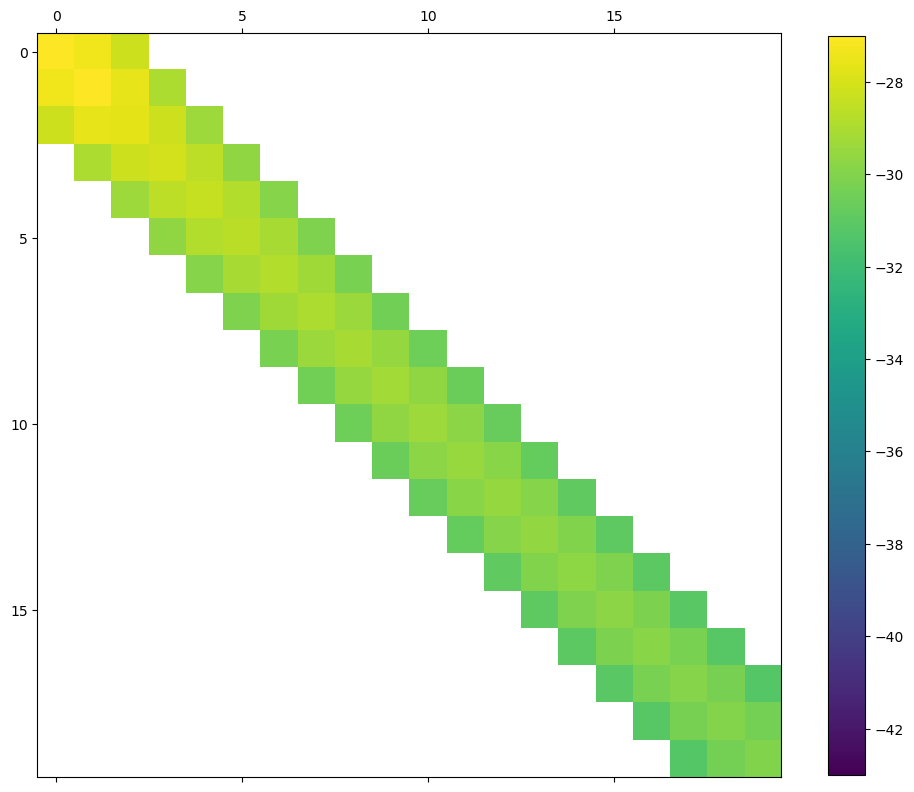

In [22]:
N_plot = 20

fig, ax = plt.subplots(1,1, figsize=[12,12])
mat = ax.matshow(np.log10(np.abs(Sigma_tilde_w_clean[:N_plot,:N_plot])), vmin=-43, vmax=-27)
cbar = fig.colorbar(mat, location='right', shrink=0.8)
# cbar.set_xticks(fontsize = 20)
# cbar.set_label(label = r'$\log_{10}|\Sigma_{n}(t,t^{\prime})|$', fontsize = 20)

In [23]:
def noise_covariance_w(Sn, w, Deltat):
    '''
    Compute N*N Fourier-domain covariance matrix for windowed process

    Fourier convention: standard, \tilde{F}(f) = \int dt e^{-2 i pi f t}F(t)

    Args:
      Sn      # Values of PSD Sn(i Deltaf), i=0,...,N/2 included (size N/2+1)
      w       # Values of window w(i Deltat), i=0,...,N-1 (size N)
      Deltat  # Value of time interval (Deltaf = 1/(N Deltat))
    '''

    N = len(w)
    Deltaf = 1./(N*Deltat)
    w_tilde = Deltat * np.fft.fft(w)

    # Values of Sn with symmetrization
    u = np.zeros(N, dtype=complex)
    u[:N//2+1] = Sn
    u[N//2+1:] = Sn[1:-1][::-1]

    Sigma_tilde_w = np.zeros((N,N), dtype=complex)
    # Compute both upper and lower diagonals (in the circulant sense, with periodicity)
    for diag_index in range(N//2+1): 
        v = w_tilde * np.conj(np.roll(w_tilde, -diag_index))
        u_tilde = np.fft.fft(u)
        v_tilde = np.fft.fft(v)
        diag_vals = Deltaf/2 * np.fft.ifft(u_tilde * v_tilde)
        rangeN = np.arange(N)
        Sigma_tilde_w[np.roll(rangeN, -diag_index), rangeN] = diag_vals
        # Separate index N/2, to avoid duplication
        if not diag_index==N//2:
            Sigma_tilde_w[rangeN, np.roll(rangeN, -diag_index)] = diag_vals

    return Sigma_tilde_w

In [26]:
Sigma_tilde_w_formula = noise_covariance_w(Sn[:N//2+1], w_t, delta_t)

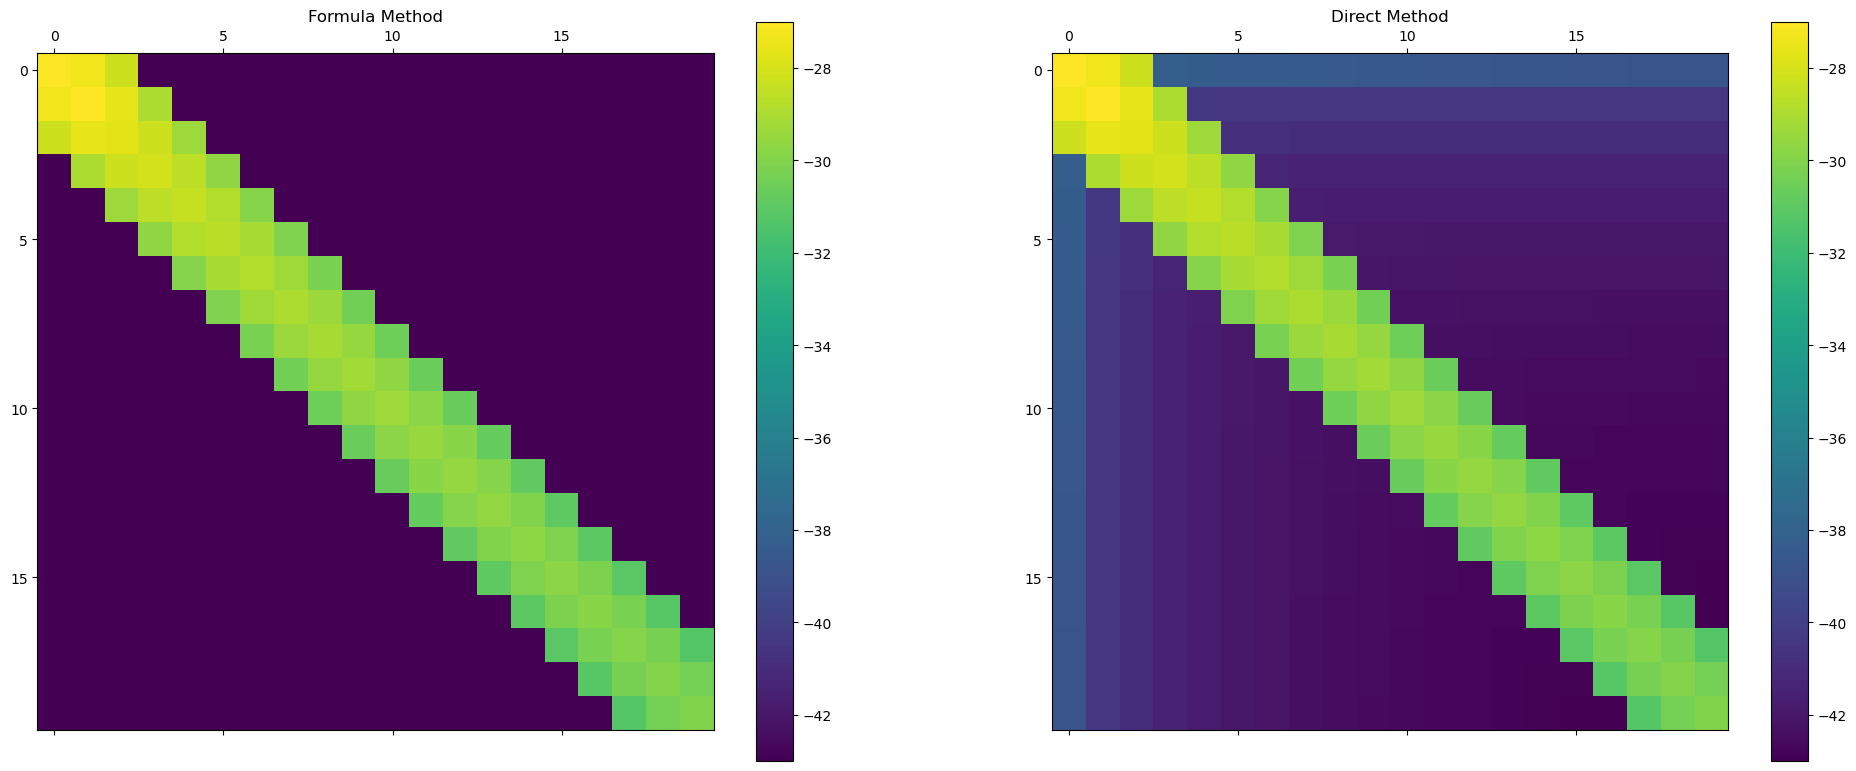

In [ ]:
N_plot = 20

Sigma_tilde_w_test = Sigma_tilde_w_formula

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[24,12])

mat1 = ax1.matshow(np.log10(np.abs(Sigma_tilde_w_formula[:N_plot,:N_plot])), vmin=-43, vmax=-27)
ax1.set_title('Formula Method')
cbar1 = fig.colorbar(mat1, ax=ax1, shrink=0.8)

mat2 = ax2.matshow(np.log10(np.abs(Sigma_tilde_w[:N_plot,:N_plot])), vmin=-43, vmax=-27)
ax2.set_title('Direct Method')
cbar2 = fig.colorbar(mat2, ax=ax2, shrink=0.8)